In [35]:
import arviz as az

try:
    import bambi as bmb
except ModuleNotFoundError:
    %pip install bambi
    import bambi as bmb
import jax
import jax.numpy as jnp
import logging
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import seaborn as sns
import tensorflow_probability.substrates.jax as tfp

from rmh import rmh_inference_loop,plot_rmh

tfd = tfp.distributions

logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

In [36]:
az.style.use("arviz-darkgrid")
key = jax.random.PRNGKey(1)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

$y = \alpha+u_j+\epsilon$

where y = response for log radon
>   $\alpha$ = global intercept. 

>  $u_j$ = Intercept specific to county j. 

>    $\epsilon$ = Residual error. 

Priors for intercepts
\begin{equation}
    \alpha = Normal(0,\sigma_{\alpha})
\end{equation}

\begin{align}
    u_j = Normal(0,\sigma_u) \\

    \sigma_u = Exponential(\tau)


\end{align}

priors for Noise:
\begin{align}
    \epsilon \sim Normal(0,\sigma_n) \\
    \sigma_n \sim Exponential(\lambda)

\end{align}

## Generate the data

In [37]:
global_intercept = 4

# noise
lambda_noise = 1
noise_exponential = tfd.Exponential(lambda_noise)
sigma_noise = noise_exponential.sample(seed=key)

# county_wise intercepts
no_counties = 10
lambda_county = 0.7
std_dev_county = tfd.Exponential(lambda_county).sample(seed=key)
county_intercepts = tfd.Normal(0,std_dev_county).sample(seed=key,sample_shape=no_counties)

# observations
radon_levels_distributions = {}
radon_lvl_obsv_countywise = {}
no_observations_per_county = jnp.abs(jnp.round((tfd.Normal(10,7).sample(seed=key,sample_shape=no_counties))))

for i in range(no_counties):
    radon_levels_distributions[i] = tfd.Normal(loc=global_intercept+county_intercepts[i],scale=sigma_noise)
    radon_lvl_obsv_countywise[i] = radon_levels_distributions[i].sample(seed=key,sample_shape=no_observations_per_county[i])


In [38]:
county_intercepts,no_observations_per_county

(DeviceArray([ 2.107743  , -1.487251  , -3.5264745 ,  0.3694462 ,
              -0.5979757 , -1.5496027 ,  2.793888  ,  5.2164736 ,
              -1.1212763 ,  0.43679175], dtype=float32),
 DeviceArray([15.,  7.,  2., 11.,  9.,  6., 16., 22.,  7., 11.], dtype=float32))

In [39]:
sigma_noise

DeviceArray(2.1357982, dtype=float32)

# Pooled Model
We will ignore the slopes for now.... (floorwise data)

In [40]:
pooled_observations = jnp.array([])
for observation in radon_lvl_obsv_countywise:
    pooled_observations =  jnp.append(pooled_observations,radon_lvl_obsv_countywise[observation])

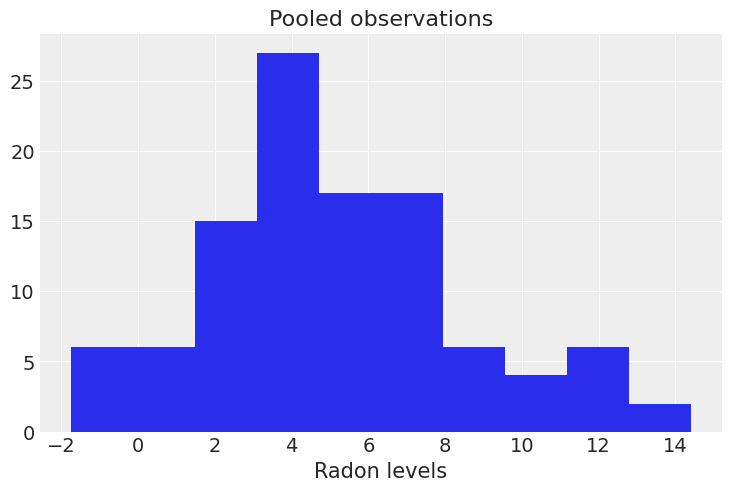

In [41]:
plt.hist(pooled_observations)
plt.title("Pooled observations")
plt.xlabel("Radon levels")
plt.show()

In [42]:
mean_prior = tfd.Normal(0,6)
sigma_prior = tfd.Exponential(2)

def log_post_fn(params):
    mean,sigma = params['mean'],params['sigma']
    log_prior_mean = mean_prior.log_prob(mean)
    log_prior_var = sigma_prior.log_prob(sigma)
    likelihood_dist = tfd.Normal(mean,sigma)
    log_likelihood = jnp.sum(likelihood_dist.log_prob(pooled_observations))
    return (log_prior_mean+log_prior_var+log_likelihood)

In [43]:

params = {
    'mean':20.0,'sigma':15.0
}
states = rmh_inference_loop(log_post_fn,jnp.ones(2)*0.7,params,10000)

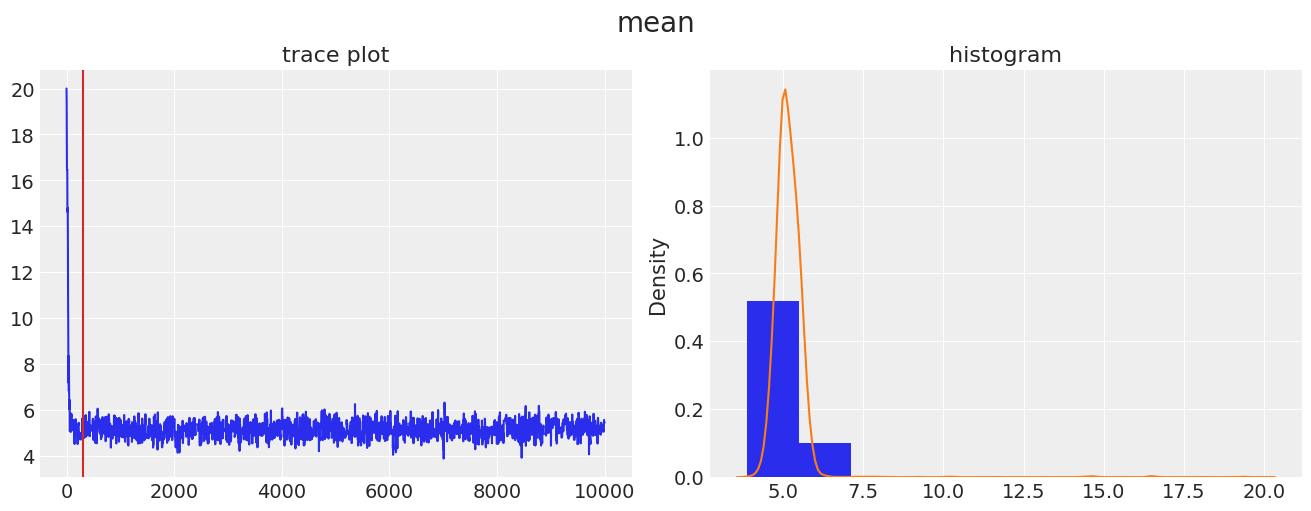

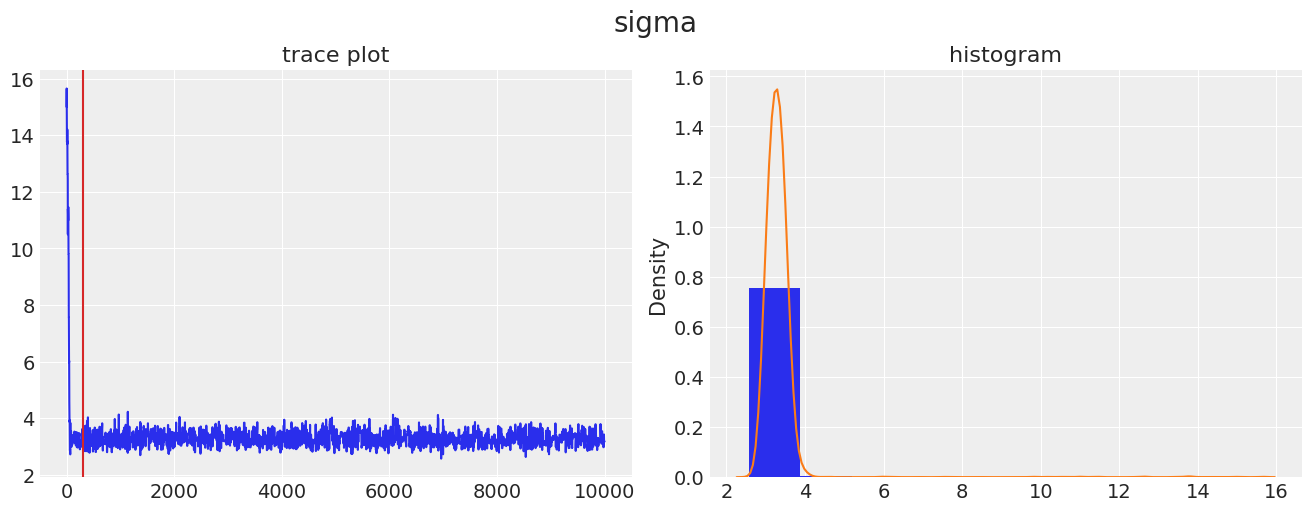

In [44]:
import seaborn as sns
import os

burnin = 300
plot_rmh(states,burnin)


# No pooling

In [45]:
radon_lvl_obsv_countywise_array = list(map(jnp.array,(list(radon_lvl_obsv_countywise.values()))))
radon_lvl_obsv_countywise_array

[DeviceArray([5.999575  , 2.480436  , 7.0832133 , 7.2916775 , 4.955208  ,
              5.71854   , 2.718     , 3.8859544 , 3.297019  , 2.913081  ,
              4.818408  , 3.8801143 , 7.332521  , 3.4927666 , 0.88145876],            dtype=float32),
 DeviceArray([ 0.7337271 ,  6.310917  , -0.79213405,  7.1345367 ,
               4.615535  , -0.8238013 , -1.7526348 ], dtype=float32),
 DeviceArray([0.22540902, 5.1989927 ], dtype=float32),
 DeviceArray([4.530593 , 2.2267983, 1.9279084, 4.0628076, 5.6304703,
              3.8007863, 4.294696 , 4.6792955, 4.874684 , 7.7072697,
              1.9435198], dtype=float32),
 DeviceArray([4.8774443, 2.3609486, 0.9334922, 3.6606367, 5.967157 ,
              2.3173022, 5.357746 , 7.0535555, 2.6171308], dtype=float32),
 DeviceArray([4.495012 , 0.3788247, 4.601288 , 3.2325058, 2.8197799,
              3.0717487], dtype=float32),
 DeviceArray([6.68572  , 3.166581 , 7.769358 , 7.9778223, 5.6413527,
              6.404685 , 3.4041448, 4.572922 , 3.983163

In [46]:
mean_prior = tfd.Normal(0,6)
sigma_prior = tfd.Exponential(2)

def log_post_fn_unpooled(params):
    mean,sigma = params['mean'],params['sigma']
    log_prior_mean = jnp.sum(mean_prior.log_prob(mean))
    
    log_prior_var = jnp.sum(sigma_prior.log_prob(sigma))
    log_likelihood = 0
    for county in range(no_counties):
        likelihood_dist = tfd.Normal(mean[county],sigma[county])
        log_likelihood += jnp.sum(likelihood_dist.log_prob(radon_lvl_obsv_countywise_array[county]))
    return (log_prior_mean+log_prior_var+log_likelihood)

params = {
    'mean': jnp.ones(no_counties),
    'sigma': jnp.ones(no_counties)*6
}
log_post_fn_unpooled(params)

DeviceArray(-469.41135, dtype=float32)

In [47]:
states = rmh_inference_loop(log_post_fn_unpooled,jnp.ones(2*no_counties)* 0.3,params,50000)

In [48]:
jnp.mean(states.position['mean'],axis=0)

DeviceArray([4.3936605, 2.194603 , 2.6081398, 4.131547 , 3.8351295,
             3.0604699, 5.404072 , 9.327142 , 2.6061628, 4.1800685],            dtype=float32)

In [49]:
# plot_rmh(states,5000,contains_arrays=True)

# Partially Pooled Model

```global_intercept = 4

# noise
lambda_noise = 1
noise_exponential = tfd.Exponential(lambda_noise)
sigma_noise = noise_exponential.sample(seed=key)

# county_wise intercepts
no_counties = 10
lambda_county = 0.7
std_dev_county = tfd.Exponential(lambda_county).sample(seed=key)
county_intercepts = tfd.Normal(0,std_dev_county).sample(seed=key,sample_shape=no_counties)

# observations
radon_levels_distributions = {}
radon_lvl_obsv_countywise = {}
no_observations_per_county = jnp.abs(jnp.round((tfd.Normal(10,7).sample(seed=key,sample_shape=no_counties))))

for i in range(no_counties):
    radon_levels_distributions[i] = tfd.Normal(loc=global_intercept+county_intercepts[i],scale=sigma_noise)
    radon_lvl_obsv_countywise[i] = radon_levels_distributions[i].sample(seed=key,sample_shape=no_observations_per_county[i])


```

In [50]:
global_sigma_prior = tfd.Exponential(1)
county_sigma_prior = tfd.Exponential(1)
global_mean_prior = tfd.Normal(0,6)

def log_post_fn_partially_pooled(params):
    mean_global,sigma_global = params['mean_global'],params['sigma_global']
    mean_county,sigma_county = params['mean_county'],params['sigma_county']

    log_prior_mean_glob = global_mean_prior.log_prob(mean_global)
    log_prior_sigma_glob = global_sigma_prior.log_prob(sigma_global)
    log_prior_sigma_county = (county_sigma_prior.log_prob(sigma_county))

    county_mean_prior = tfd.Normal(0,sigma_county)
    log_prior_mean_county = jnp.sum(county_mean_prior.log_prob(mean_county))
    log_likelihood = 0
    for county in range(no_counties):
        likelihood_dist = tfd.Normal(mean_county[county]+mean_global,sigma_global)
        log_likelihood += jnp.sum(likelihood_dist.log_prob(radon_lvl_obsv_countywise_array[county]))

    return log_prior_mean_glob+log_prior_sigma_glob+log_prior_sigma_county+log_prior_mean_county+log_likelihood

params = {
    'mean_global': 0.,
    'sigma_global':6.0,
    'mean_county': jnp.ones(no_counties)*1.,
    'sigma_county': 4.0
}
log_post_fn_partially_pooled(params)

DeviceArray(-365.1725, dtype=float32)

In [51]:
states = rmh_inference_loop(log_post_fn_partially_pooled,jnp.ones(no_counties+3)*0.8,params,100000)

In [52]:
states.position.keys()

dict_keys(['mean_county', 'mean_global', 'sigma_county', 'sigma_global'])

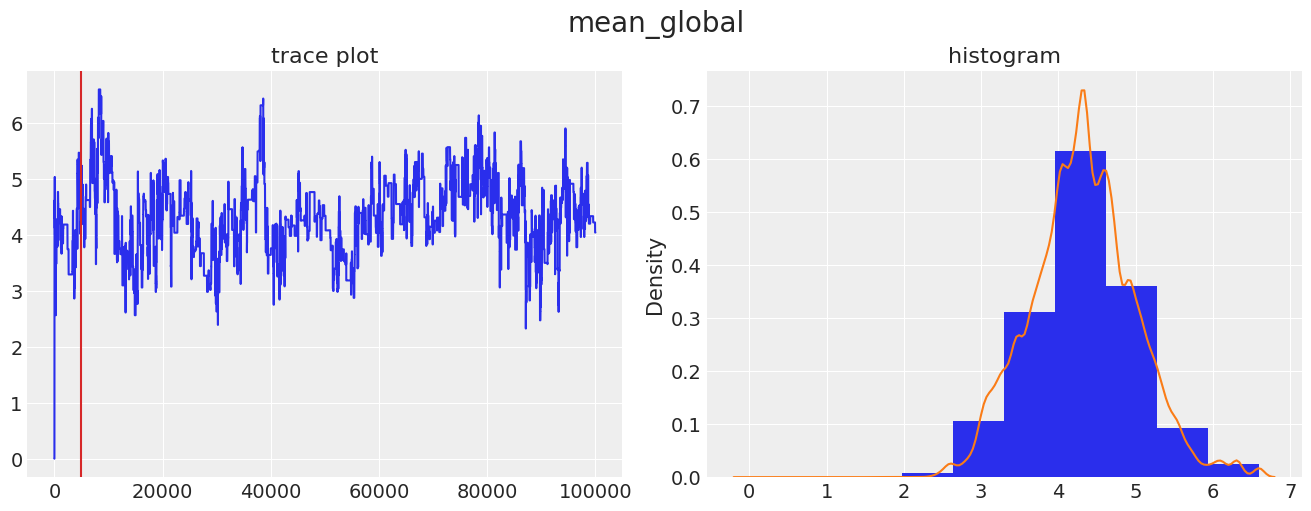

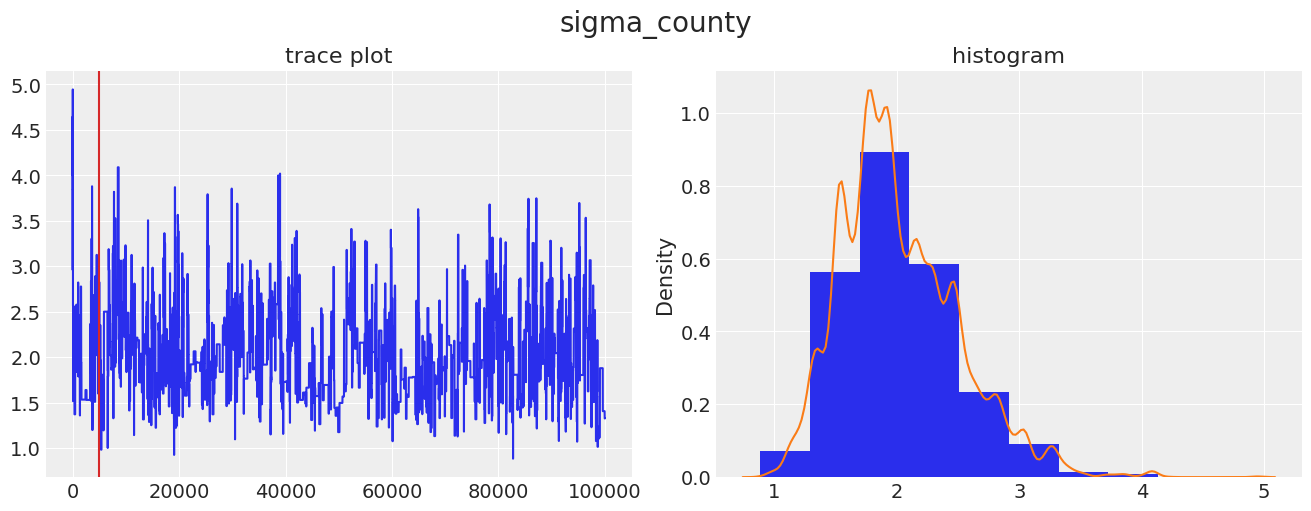

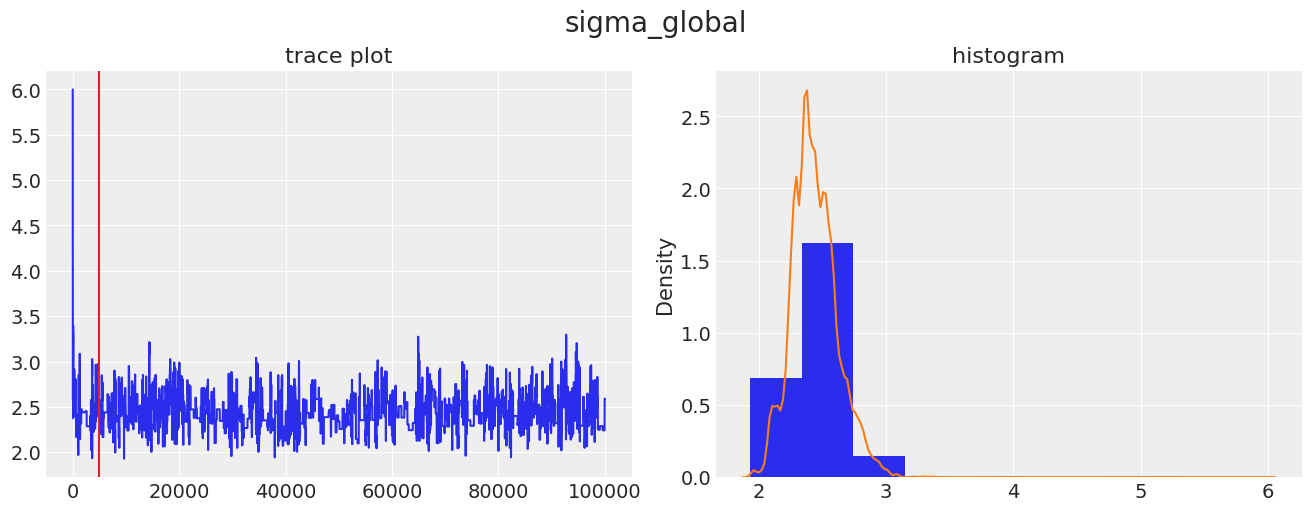

In [53]:
mean_counties = states.position['mean_county']
del states.position['mean_county']
plot_rmh(states,5000)

30000


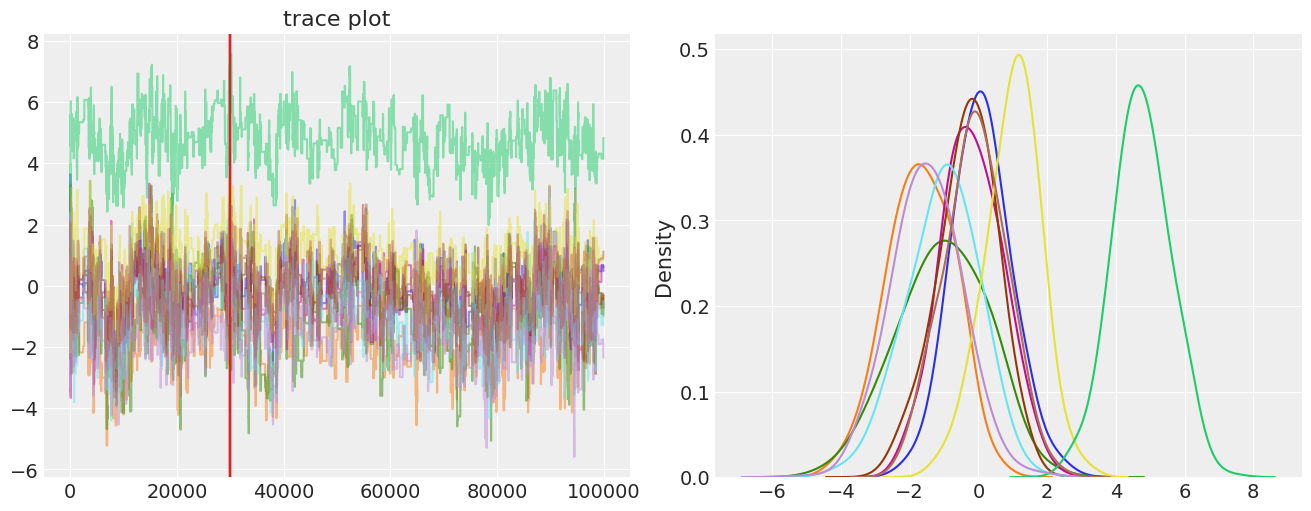

In [54]:
def plot_rmh_array(states_position,burnin=None):
    if(burnin==None):
        burnin=int(states_position.shape[0]*0.3)
    print(burnin)
    fig, (ax,ax1) = plt.subplots(1,2,figsize=(13,5))
    for i in range(states_position.shape[1]):
        ax.plot(states_position[:,i],alpha=0.5)
        ax.set_title('trace plot')
        ax.axvline(x=burnin, c="tab:red")
        # ax1.hist(states_position[burnin:,i],density=True)
        sns.kdeplot(states_position[burnin:,i],ax=ax1,bw_adjust=4)
    plt.show()
plot_rmh_array(mean_counties)

In [22]:
jnp.mean(mean_counties[burnin:,:],axis=0)

DeviceArray([ 0.09005088, -1.6837277 , -0.917917  , -0.14263985,
             -0.30544695, -0.95931363,  1.0428778 ,  4.795423  ,
             -1.4843621 , -0.08376679], dtype=float32)

In [27]:
jnp.mean(states.position['mean_global'])

DeviceArray(4.3150754, dtype=float32)

In [28]:
county_intercepts

DeviceArray([ 2.107743  , -1.487251  , -3.5264745 ,  0.3694462 ,
             -0.5979757 , -1.5496027 ,  2.793888  ,  5.2164736 ,
             -1.1212763 ,  0.43679175], dtype=float32)

In [32]:
states

RMHState(position={'mean_global': DeviceArray([0.     , 0.     , 0.     , ..., 4.03873, 4.03873, 4.03873],            dtype=float32, weak_type=True), 'sigma_county': DeviceArray([4.       , 4.       , 4.       , ..., 1.3275453, 1.3275453,
             1.3275453], dtype=float32, weak_type=True), 'sigma_global': DeviceArray([6.      , 6.      , 6.      , ..., 2.590834, 2.590834,
             2.590834], dtype=float32, weak_type=True)}, log_probability=DeviceArray([-365.1725 , -365.1725 , -365.1725 , ..., -272.42963,
             -272.42963, -272.42963], dtype=float32))

Text(0.5, 1.0, 'log Probability')

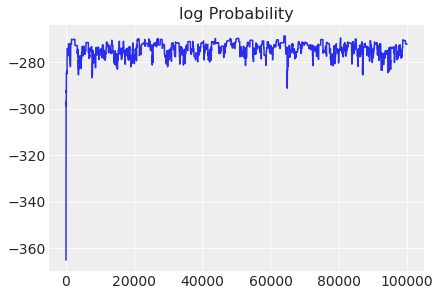

In [34]:
plt.plot(states.log_probability)
plt.title("log Probability")